Este agarra el CSV de todas las especies, y carga los CSVs recortados para procesar y entrenar

### Modify these bounds and values for Data Selection

In [ ]:
# Bounding box for Latin America (min_lat, max_lat, min_lon, max_lon)
latin_america_bounds = {
    "lat": (-55.0, -20),
    "lon": (-73, -53)
}

MIN_SAMPLES_CUTOFF = 25
MIN_RATING_CUTOFF = 2.5

### The rest of the code below should remain unchanged.

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import librosa
import numpy as np
from collections import defaultdict

In [ ]:
# # Work is done, csv ya procesado
# # Load original CSV
# df = pd.read_csv('../database/train_metadata.csv')

# # Drop rows without coordinates
# df = df.dropna(subset=['latitude', 'longitude', 'filename', 'scientific_name', 'primary_label'])

# # Keep only specified columns
# cols = ['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'filename', 'rating', 'author']
# df = df[cols]

# # Overwrite original file
# df.to_csv('../data/birdclef-2021/train_metadata.csv', index=False)
# df.to_csv('../database/train_metadata.csv', index=False)

# # Preview
# df.head(n=10)

In [ ]:
df = pd.read_csv(os.path.join('..', 'database', 'train_metadata.csv'))
print(f"DataFrame shape: {df.shape}")
df = df.dropna(subset=['latitude', 'longitude'])
df = df[df['filename'].notna() & (df['filename'] != '')]
df = df[~(df['scientific_name'].isna() & df['common_name'].isna())]
print(f"DataFrame shape after 'cuts': {df.shape}")
df.head(n=10)

In [14]:
def in_region(lat, lon):
    return (latin_america_bounds['lat'][0] <= lat <= latin_america_bounds['lat'][1] and
            latin_america_bounds['lon'][0] <= lon <= latin_america_bounds['lon'][1])

df['region'] = df.apply(lambda row: 'Latin America' if in_region(row['latitude'], row['longitude']) else None, axis=1)
region_df = df[df['region'].notna()][['primary_label', 'latitude', 'longitude', 'scientific_name', 'common_name', 'region', 'filename']]

# Add sample count per species
species_counts = region_df['scientific_name'].value_counts().to_dict()
region_df['amount_of_samples'] = region_df['scientific_name'].map(species_counts)

total_samples = len(region_df)
total_species = region_df['scientific_name'].nunique()

print(f"Total samples: {total_samples}")
print(f"Total distinct species: {total_species}")

Total samples: 961
Total distinct species: 78


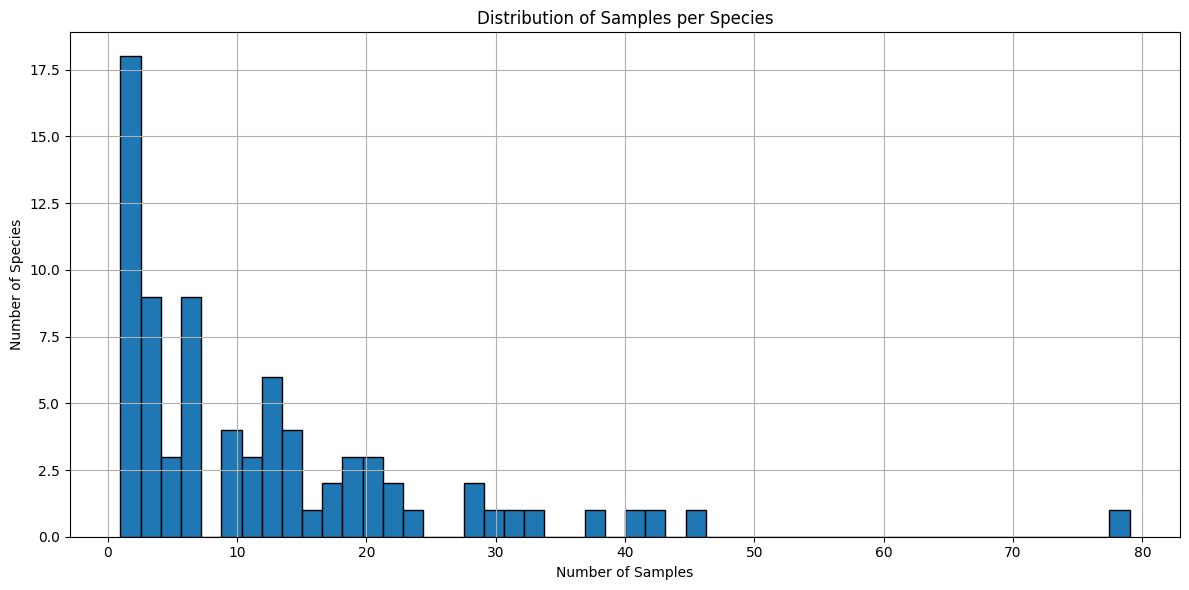

In [25]:
species_counts = region_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species')
plt.grid(True)
plt.tight_layout()
plt.show()

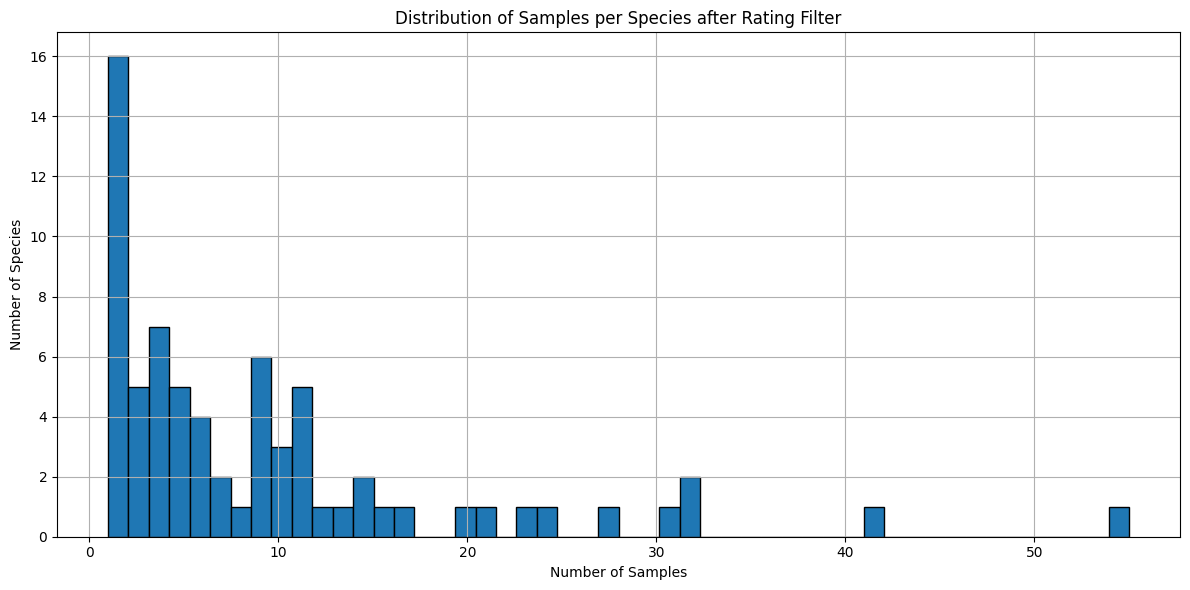

Total samples: 667
Total distinct species: 70


In [26]:
rated_df = region_df[df.loc[region_df.index, 'rating'] >= MIN_RATING_CUTOFF]
rated_species_counts = rated_df['scientific_name'].value_counts()

plt.figure(figsize=(12, 6))
rated_species_counts.hist(bins=50, edgecolor='black')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Species')
plt.title('Distribution of Samples per Species after Rating Filter')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total samples: {len(rated_df)}")
print(f"Total distinct species: {rated_df['scientific_name'].nunique()}")

In [ ]:
# Assuming rated_df is your DataFrame and contains 'primary_label' and 'filename' columns
segment_sec = 5.0
sr = 32000
samples_per_segment = int(sr * segment_sec)
frame_len = 2048
hoplen = 512
thresh_factor = 0.7

usable_segments = []

for _, row in rated_df.iterrows():
    primary_label = row['primary_label']
    filename = row['filename']
    audio_path = os.path.join('../data/birdclef-2021/train_short_audio', primary_label, filename)

    try:
        y, srate = librosa.load(audio_path, sr=sr, mono=True)
    except Exception as e:
        print(f"Error loading audio file {audio_path}: {e}")
        usable_segments.append(0)
        continue

    rms = librosa.feature.rms(y=y, frame_length=frame_len, hop_length=hoplen)[0]
    threshold = thresh_factor * np.mean(rms)
    count = 0

    for start in range(0, len(y) - samples_per_segment + 1, samples_per_segment):
        segment = y[start:start + samples_per_segment]
        seg_rms = np.mean(librosa.feature.rms(y=segment)[0])
        if seg_rms < threshold:
            continue
        count += 1

    usable_segments.append(count)

segs_df = rated_df.copy()
rated_df['usable_segments'] = usable_segments

In [ ]:
seg_counts = rated_df['usable_segments'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
plt.bar(seg_counts.index, seg_counts.values, edgecolor='black', align='center')
plt.xlabel('Number of Samples')
plt.ylabel('Number of Usable Segments')
plt.title('Number of Usable Segments per Number of Samples')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
seg_counts_filtered = segs_df['usable_segments'] > MIN_SAMPLES_CUTOFF
minsmps_df = segs_df[seg_counts_filtered]

plt.figure(figsize=(12, 6))
minsmps_df['usable_segments'].hist(bins=100, edgecolor='black')
plt.xlabel('Number of Usable Segments')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples with Usable Segments > MIN_SAMPLES_CUTOFF')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"Total samples: {len(minsmps_df)}")
print(f"Total distinct species: {minsmps_df['scientific_name'].nunique()}")

In [18]:
# Final Amount of Samples and Species
print(f"Final amount of samples: {len(minsmps_df)}")
print(f"Final amount of species: {minsmps_df['scientific_name'].nunique()}")

Final amount of samples: 505
Final amount of species: 28


In [19]:
# # Load the Class IDs for training
# final_df = minsmps_df[['primary_label', 'scientific_name', 'common_name', 'filename']].copy()

# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# final_df['class_id'] = le.fit_transform(final_df['scientific_name'])

# # Save species to CSV
# final_df.to_csv(os.path.join('..', 'database', 'meta', 'final_species.csv'), index=False)

# # Build mapping with class_id, scientific_name, common_name
# mapping_df = final_df[['class_id', 'scientific_name', 'common_name']].drop_duplicates().sort_values('class_id')
# mapping_df.to_csv(os.path.join('..', 'database', 'meta', 'class_mapping.csv'), index=False)